# Graph quality evaluation
In this notebook, we'll undertake some qualitative and quantitative approaches to evaluating the quality of the various graph generation approaches we've used.

For the sake of this notebooks, "graph quality" refers to the underlying performance of the entity and relation extraction pipelines that are used to build the graph. This decision is based on the assumption that a "gold standard" graph, when built from unstructured scientific articles, is a graph where relations and entities were perfectly extracted from the original source.

In [34]:
import jsonlines
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import networkx as nx
from math import comb
from statistics import median
import json
import pandas as pd
from tqdm import tqdm

## Use PICKLE dataset as a baseline quantitative metric
While we don't have a gold standard of entities and relations for our drought/desiccation dataset, we do have access to the [PICKLE dataset](https://huggingface.co/datasets/slotreck/pickle), which has a gold-standard set of entities and relations labeled on 250 plant science abstracts. We'll use the PICKLE dataset to set an expectation for what quantity and ratio of entities and relations we think we should see in our larger drought/desiccation corpus. If our graphs fall far short of the kind of relation/entity ratio that we see in PICKLE, we can say that likely, the recall of the method(s) is poor.

To provide more compelling evidence that PICKLE is a reasonable comparison to our drought/desiccation dataset, we'll also do some comparisons of more basic statistics like abstract length, average word length, and average sentence length.

In [2]:
with jsonlines.open('../data/pickle/pickle_all.jsonl') as reader:
    pickle = [obj for obj in reader]

In [3]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    drought_des = [obj for obj in reader]

In [4]:
datasets = {
    'PICKLE': pickle,
    'drought + desiccation': drought_des
}

### Basic dataset comparisons

In [5]:
abstract_lens = defaultdict(list)
sent_lens = defaultdict(list)
word_lens = defaultdict(list)
for dset_name, dataset in datasets.items():
    for doc in dataset:
        abstract_lens[dset_name].append(len(doc['sentences']))
        for sent in doc['sentences']:
            sent_lens[dset_name].append(len(sent))
            for tok in sent:
                word_lens[dset_name].append(len(tok))
basic_stats = {
    'sentences per abstract': abstract_lens,
    'words per sentence': sent_lens,
    'letters per word': word_lens
}

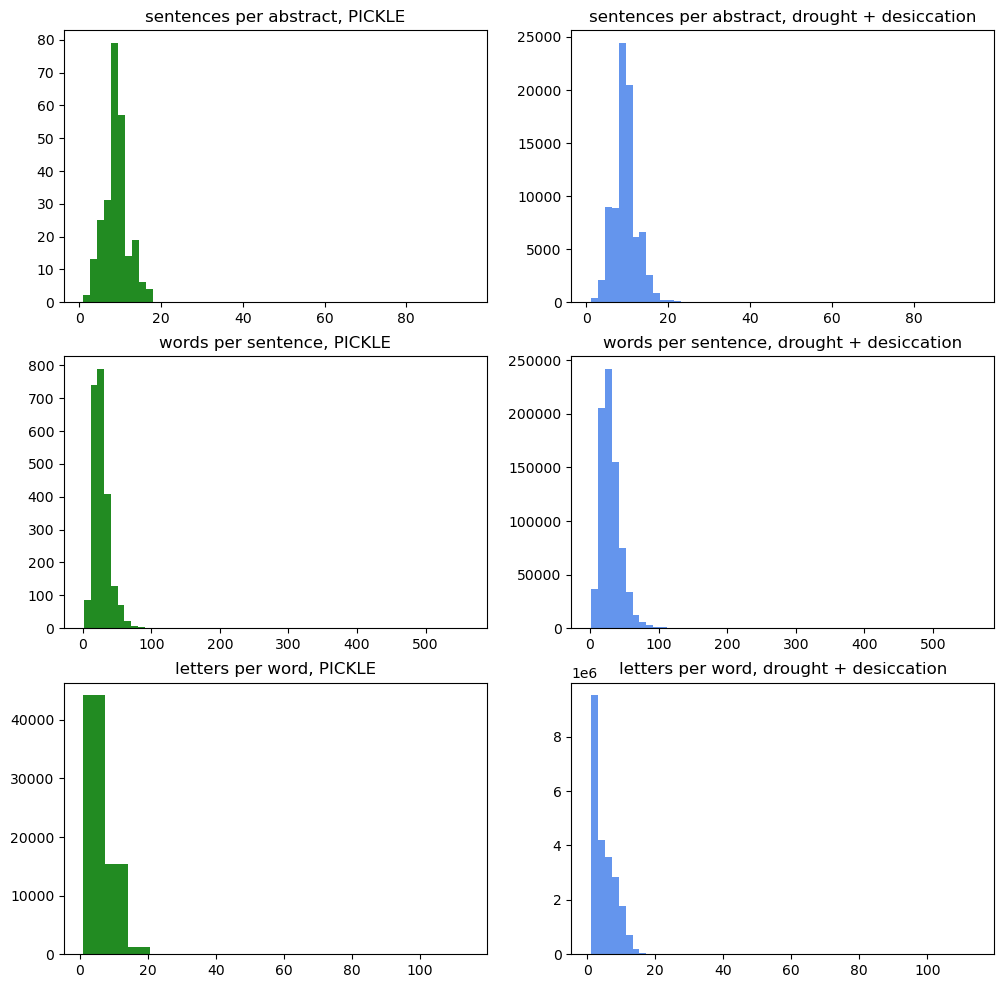

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12,12), sharex='row')
colors = {'PICKLE': 'forestgreen', 'drought + desiccation': 'cornflowerblue'}
for stat, axz in zip(basic_stats, axs):
    for dset_name, ax in zip(basic_stats[stat], axz):
        vals = basic_stats[stat][dset_name]
        if dset_name == 'PICKLE':
            _, bins, _ = ax.hist(vals, label=dset_name, color=colors[dset_name])
        elif dset_name == 'drought + desiccation':
            ax.hist(vals, bins=len(bins)*5, label=dset_name, color=colors[dset_name])
        ax.set_title(f'{stat}, {dset_name}')
plt.savefig('../data/figures/basic_dataset_statistics_comparison_pickle.pdf', format='pdf',
           bbox_inches='tight', dpi=600)

Figure caption: Histograms of basic dataset statistics for the PICKLE and drought/desiccation dataset. X-limits for each row are determined by the automatic x-limits for the drought/desiccation dataset, as it has larger ourliers in each category. Default number of bins was used for PICKLE, and 5x the number of PICKLE bins was used for drought/desiccation in each row to allow a similar level of granularity for comparison.

In [7]:
max_vals = {
    stat: {
        dset: max(vals)
        for dset, vals in stat_val.items()
    } for stat, stat_val in basic_stats.items()
}

In [8]:
max_vals

{'sentences per abstract': {'PICKLE': 18, 'drought + desiccation': 95},
 'words per sentence': {'PICKLE': 100, 'drought + desiccation': 561},
 'letters per word': {'PICKLE': 66, 'drought + desiccation': 114}}

### Calculation of the ratio
We'll do this both for the overall dataset, as well as on a per-abstract level, so that we can compare distributions as well.

In [9]:
ents_per_abstract = defaultdict(int)
rels_per_abstract = defaultdict(int)
for doc in pickle:
    entcount = 0
    relcount = 0
    for sent in doc['ner']:
        entcount += len(sent)
    for sent in doc['relations']:
        relcount += len(sent)
    ents_per_abstract[doc['doc_key']] = entcount
    rels_per_abstract[doc['doc_key']] = relcount

In [10]:
total_ratio = sum(rels_per_abstract.values())/sum(ents_per_abstract.values())
print(f'The PICKLE dataset has a relation to entity ratio of {total_ratio:.2f}')

The PICKLE dataset has a relation to entity ratio of 0.34


In [11]:
per_doc_ratios = {doc['doc_key']: rels_per_abstract[doc['doc_key']]/ents_per_abstract[doc['doc_key']] for doc in pickle}

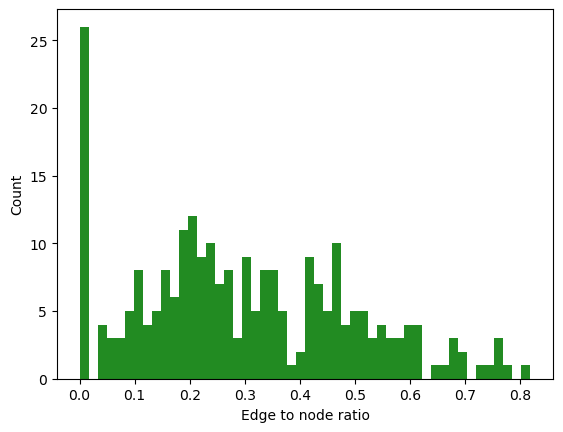

In [12]:
_ = plt.hist(per_doc_ratios.values(), bins=50, color=colors['PICKLE'])
_ = plt.xlabel('Edge to node ratio')
_ = plt.ylabel('Count')

## Evaluating available graphs
### DyGIE++

In [13]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    dygiepp_preds = [obj for obj in reader]

In [14]:
dygiepp_graph = nx.read_graphml('../data/kg/dygiepp_pure_extraction_graph.graphml')

In [15]:
print(f'The DyGIE++-derived graph has {len(dygiepp_graph.nodes)} nodes and {len(dygiepp_graph.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_graph.degree])}.')

The DyGIE++-derived graph has 336120 nodes and 124408 edges.
268851 of these nodes are isolates, and the median node degree is 0.0.


In [16]:
ents_per_abstract_dygiepp = defaultdict(int)
rels_per_abstract_dygiepp = defaultdict(int)
for doc in dygiepp_preds:
    entcount = 0
    relcount = 0
    for sent in doc['predicted_ner']:
        entcount += len(sent)
    for sent in doc['predicted_relations']:
        relcount += len(sent)
    ents_per_abstract_dygiepp[doc['doc_key']] = entcount
    rels_per_abstract_dygiepp[doc['doc_key']] = relcount

In [17]:
total_ratio_dygiepp = sum(rels_per_abstract_dygiepp.values())/sum(ents_per_abstract_dygiepp.values())
print(f'The DyGIE++-derived graph has a relation to entity ratio of {total_ratio_dygiepp:.2f}')

The DyGIE++-derived graph has a relation to entity ratio of 0.09


In [18]:
per_doc_ratios_dygiepp = {}
for doc in dygiepp_preds:
    try:
        per_doc_ratios_dygiepp[doc['doc_key']] = rels_per_abstract_dygiepp[doc['doc_key']]/ents_per_abstract_dygiepp[doc['doc_key']]
    except ZeroDivisionError:
        per_doc_ratios_dygiepp[doc['doc_key']] = 0

### DyGIE++ co-occurrence

In [19]:
dygiepp_co_occurrence = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_02May2024.graphml')

In [20]:
print(f'The co-occurrence graph has {len(dygiepp_co_occurrence.nodes)} nodes and {len(dygiepp_co_occurrence.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_co_occurrence)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_co_occurrence.degree])}.')

The co-occurrence graph has 334579 nodes and 1289214 edges.
35054 of these nodes are isolates, and the median node degree is 3.


In [21]:
total_ratio_co_occurrence = len(dygiepp_co_occurrence.edges)/len(dygiepp_co_occurrence)
print(f'The co-occurrence graph has a relation to entity ratio of {total_ratio_co_occurrence:.2f}')

The co-occurrence graph has a relation to entity ratio of 3.85


To calculate the ratio on a per-document basis, we need to go back to the predictions:

In [22]:
per_doc_ratios_co_occurrence = defaultdict(int)
for doc in drought_des:
    ents = 0
    rels = 0
    for sent in doc['predicted_ner']:
        if len(sent) > 1:
            rels += comb(len(sent), 2)
        ents += len(sent)
    try:
        per_doc_ratios_co_occurrence[doc['doc_key']] = rels/ents
    except ZeroDivisionError:
        per_doc_ratios_co_occurrence[doc['doc_key']] = 0

### OpenIE

In [23]:
openie_graph = nx.read_graphml('../data/kg/openIE_filtered_graph_08May2024.graphml')

In [24]:
print(f'The OpenIE graph has {len(openie_graph.nodes)} nodes and {len(openie_graph.edges)} edges.')
print(f'{len(list(nx.isolates(openie_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in openie_graph.degree])}.')

The OpenIE graph has 6195 nodes and 8156 edges.
0 of these nodes are isolates, and the median node degree is 1.


In [25]:
total_ratio_openie = len(openie_graph.edges)/len(openie_graph.nodes)
print(f'The openIE graph has a relation to entity ratio of {total_ratio_openie:.2f}')

The openIE graph has a relation to entity ratio of 1.32


Read in the per-doc triples to get the per-doc ratio:

In [26]:
with open('../data/kg/openIE_per_doc_filtered_triples_21May2024.json') as f:
    filtered_openie_trips = json.load(f)

In [27]:
per_doc_ratios_openie = {}
for doc, trips in filtered_openie_trips.items():
    ents = []
    num_rels = len(trips)
    for trip in trips:
        ents.append(trip['subject'])
        ents.append(trip['object'])
    unique_ents = set(ents)
    doc_ratio = num_rels/len(unique_ents)
    per_doc_ratios_openie[doc] = doc_ratio

### OntoGPT

In [28]:
ontogpt_graph = nx.read_graphml('../data/kg/ontogpt_cleaned_graph_22May2024.graphml')

In [29]:
print(f'The OntoGPT graph has {len(ontogpt_graph.nodes)} nodes and {len(ontogpt_graph.edges)} edges.')
print(f'{len(list(nx.isolates(ontogpt_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in ontogpt_graph.degree])}.')

The OntoGPT graph has 12488 nodes and 3023 edges.
9981 of these nodes are isolates, and the median node degree is 0.0.


In [30]:
total_ratio_ontogpt = len(ontogpt_graph.edges)/len(ontogpt_graph.nodes)
print(f'The OntoGPT graph has a relation to entity ratio of {total_ratio_ontogpt:.2f}')

The OntoGPT graph has a relation to entity ratio of 0.24


In [31]:
onto_ents = pd.read_csv('../data/kg/ontogpt_slim_ent_df_CLEANED_20May2024.csv')
onto_rels = pd.read_csv('../data/kg/ontogpt_slim_rel_df_CLEANED_20May2024.csv')

In [32]:
doc_ids = set(onto_ents.provided_by.unique().tolist() + onto_rels.provided_by.unique().tolist())

In [38]:
counted_ents = onto_ents.groupby('provided_by').count()
counted_rels = onto_rels.groupby('provided_by').count()

In [39]:
counted_ents.head()

,id,category,name
provided_by,,,
00159f63-f25f-4b12-a92b-cc4803afaf19,12341,12341,12336
001cb325-9ae3-4f50-a586-a9109e12455c,5215,5215,5212
00287dc5-4c7b-4e9b-ae1c-c05e7a86c1ad,697,697,697
00481fc8-f30d-40c8-91f7-01ec2f2922f7,8575,8575,8572
004efc2b-ce2a-4f84-9700-fd85536636f1,3726,3726,3726


In [41]:
len(onto_ents['provided_by'].unique())

5237

In [40]:
onto_ents[onto_ents['provided_by'] == '00159f63-f25f-4b12-a92b-cc4803afaf19']

,id,category,name,provided_by
35140786,AUTO:lipid%20peroxidation,Molecule,lipid peroxidation,00159f63-f25f-4b12-a92b-cc4803afaf19
35140787,CHEBI:16856,Molecule,glutathione,00159f63-f25f-4b12-a92b-cc4803afaf19
35140788,CHEBI:29191,Molecule,hydroxyl radical,00159f63-f25f-4b12-a92b-cc4803afaf19
35140789,AUTO:Trichilia%20dregeana,Organism,Trichilia dregeana,00159f63-f25f-4b12-a92b-cc4803afaf19
35140790,CHEBI:22152,Molecule,abscisic acid,00159f63-f25f-4b12-a92b-cc4803afaf19
...,...,...,...,...
35153122,AUTO:herbaceous%20grassland%20species,Organism,herbaceous grassland species,00159f63-f25f-4b12-a92b-cc4803afaf19
35153123,AUTO:common%20perennial%20European%20temperate...,Organism,common perennial European temperate mesic gras...,00159f63-f25f-4b12-a92b-cc4803afaf19
35153124,AUTO:NAG,Gene,NAG,00159f63-f25f-4b12-a92b-cc4803afaf19
35153125,AUTO:methyltransferase,Gene,methyltransferase,00159f63-f25f-4b12-a92b-cc4803afaf19


In [37]:
per_doc_ratios_ontogpt = {}
for doc in tqdm(doc_ids):
    num_ents = counted_ents.loc[doc]
    print(num_ents)
#     num_rels = len(onto_rels[onto_rels['provided_by'] == doc])
#     per_doc_ratios_ontogpt[doc] = num_rels/num_ents

 11%|█▏        | 594/5237 [00:00<00:01, 2968.44it/s]

id          9950
category    9950
name        9945
Name: b1ef4811-4212-4bfc-9aeb-546ca1fba88f, dtype: int64
id          9184
category    9184
name        9181
Name: 514a470e-ecb7-41dc-8dec-460f91769e40, dtype: int64
id          10984
category    10984
name        10979
Name: 42a97230-52cf-477b-b1b1-321e3336f81b, dtype: int64
id          9456
category    9456
name        9453
Name: eb509247-fd2e-4114-9e7b-9d3cfc5f0e49, dtype: int64
id          5804
category    5804
name        5801
Name: 5ca7a37d-265f-4009-8da5-97734b43501d, dtype: int64
id          4900
category    4900
name        4897
Name: a11bd33c-ade0-478e-a554-3bd3f9558a62, dtype: int64
id          5760
category    5760
name        5757
Name: dc7213fe-8f73-485e-9284-71769727c8ed, dtype: int64
id          9729
category    9729
name        9724
Name: 25d0bb92-b64a-4ea6-94af-398b9c7310cb, dtype: int64
id          10432
category    10432
name        10427
Name: 0f194e49-fbcc-446b-8f2c-5ced47356387, dtype: int64
id          2932
categ

 23%|██▎       | 1195/5237 [00:00<00:01, 2958.24it/s]

id          6831
category    6831
name        6828
Name: 17a40416-92bd-4f3a-af23-861470ff3748, dtype: int64
id          8969
category    8969
name        8966
Name: 9ff08e1d-52f5-4e84-a48e-ba741d5345bb, dtype: int64
id          1595
category    1595
name        1595
Name: fcfcdc40-6196-4edc-9b07-927c0b149fe9, dtype: int64
id          11424
category    11424
name        11419
Name: 54a7f5b4-5859-44e6-b00c-1a912b9b7b17, dtype: int64
id          883
category    883
name        883
Name: c5177b89-c4b8-444a-bdab-16c7ab140ca3, dtype: int64
id          3462
category    3462
name        3462
Name: a1db8cb2-3cd0-4433-b5f8-7213d15bb5d0, dtype: int64
id          4669
category    4669
name        4668
Name: c86a921f-fc1f-4a0e-b56a-1de3b4e11e8f, dtype: int64
id          6694
category    6694
name        6691
Name: 121c1680-1aec-4ce7-8643-7be83565ecee, dtype: int64
id          11483
category    11483
name        11478
Name: f4010d42-66dc-4281-b7b2-7192dc31b8df, dtype: int64
id          12283
categor

 34%|███▍      | 1798/5237 [00:00<00:01, 2985.18it/s]

id          4349
category    4349
name        4348
Name: b2d3a12c-613b-4ba2-be97-666a9f282441, dtype: int64
id          10217
category    10217
name        10212
Name: f04233a2-6e99-4154-8d59-f6c6037004c8, dtype: int64
id          9952
category    9952
name        9947
Name: 6fdd641e-6dd2-47cb-95f2-78b9a1ead58e, dtype: int64
id          11556
category    11556
name        11551
Name: f0ee046c-0c51-4b9a-bfad-28775be22eee, dtype: int64
id          4276
category    4276
name        4275
Name: 6e5b5d5c-f07f-4128-b2eb-aad801d518f3, dtype: int64
id          10588
category    10588
name        10583
Name: 0e8c766d-eb60-4866-94ab-544b036c4e70, dtype: int64
id          11978
category    11978
name        11973
Name: 4cad4394-9656-4eca-828c-4ef69ef88eb1, dtype: int64
id          6711
category    6711
name        6708
Name: a87ebbdd-7735-411c-b30c-7c2b687a5eab, dtype: int64
id          11868
category    11868
name        11863
Name: a08759a9-479f-4237-8ec4-65dd47a349a2, dtype: int64
id          1

 46%|████▌     | 2404/5237 [00:00<00:00, 2994.57it/s]

id          7063
category    7063
name        7060
Name: 4f191a84-b941-4aa8-af7b-077fc924046e, dtype: int64
id          8310
category    8310
name        8307
Name: b116dc20-a9ca-48c2-aa8f-caccfc23e57b, dtype: int64
id          5190
category    5190
name        5187
Name: 94b18df6-6f8e-48a3-990f-03ecbbf8a548, dtype: int64
id          7315
category    7315
name        7312
Name: a59d202c-660a-45b2-938c-84ae77c7c982, dtype: int64
id          5557
category    5557
name        5554
Name: 4b912316-f88f-407d-a5a9-242230ad969e, dtype: int64
id          4028
category    4028
name        4028
Name: 5b584613-0846-40c5-a920-587f90b225cc, dtype: int64
id          6732
category    6732
name        6729
Name: 4634bc65-3eb5-4f7c-a7f5-d0ca89464dc5, dtype: int64
id          904
category    904
name        904
Name: 8808be9e-1615-432d-af5e-50a950efdba4, dtype: int64
id          365
category    365
name        365
Name: 84839d38-6b40-4397-b73c-321a4dd68574, dtype: int64
id          6787
category    6787


 57%|█████▋    | 3010/5237 [00:01<00:00, 2993.35it/s]

id          1157
category    1157
name        1157
Name: dab96dce-b216-459d-972c-b5f80e0df85e, dtype: int64
id          9074
category    9074
name        9071
Name: 8d71f896-d774-446f-992c-02d237744459, dtype: int64
id          12052
category    12052
name        12047
Name: 03a871ce-1659-40e8-a445-7bc1ddc53ef0, dtype: int64
id          10694
category    10694
name        10689
Name: ede2d663-1c69-42a4-9830-ce3431b0f68d, dtype: int64
id          7680
category    7680
name        7677
Name: cc14434c-c497-4dc1-8bd7-8194c16e0f09, dtype: int64
id          6197
category    6197
name        6194
Name: 2fc43858-909f-474a-9530-de5fa7fd5155, dtype: int64
id          4305
category    4305
name        4304
Name: dadbf293-74e1-4f70-b576-df00cc2601a8, dtype: int64
id          5004
category    5004
name        5001
Name: e1a34cdb-361c-4f02-9e42-db5fd2a934ad, dtype: int64
id          2701
category    2701
name        2701
Name: da649e28-0d97-46ff-a568-a760a8955eae, dtype: int64
id          606
catego

 69%|██████▉   | 3611/5237 [00:01<00:00, 2975.84it/s]

id          5795
category    5795
name        5792
Name: a6d203e2-0751-4dbb-9ec1-ba8ead9db4d7, dtype: int64
id          8872
category    8872
name        8869
Name: 5c919563-152a-4608-9a27-741ceeecc677, dtype: int64
id          554
category    554
name        554
Name: 7195a5e5-af82-4d75-8023-3e9cab96b9d8, dtype: int64
id          7507
category    7507
name        7504
Name: 1a1cae84-5b63-46c5-b452-cf9fb81e1143, dtype: int64
id          7756
category    7756
name        7753
Name: 39845cd0-5a62-4a41-a828-c500cfeff663, dtype: int64
id          4741
category    4741
name        4740
Name: 0634c810-cb54-49c6-b930-5deaf51183b6, dtype: int64
id          2671
category    2671
name        2671
Name: 1977b234-ec66-4611-bd6d-8588f28c9e87, dtype: int64
id          9355
category    9355
name        9352
Name: 79272121-0b51-4c51-8737-5fbc1346bf51, dtype: int64
id          109
category    109
name        109
Name: 6f323fac-0f01-4f76-9d1d-cbb49613e975, dtype: int64
id          11751
category    1175

 80%|████████  | 4215/5237 [00:01<00:00, 2983.62it/s]

id          6692
category    6692
name        6689
Name: 5cb84c9f-71e6-447b-a7b3-4c3ed217acee, dtype: int64
id          6796
category    6796
name        6793
Name: f5a30a61-bcdb-4ce5-985b-18ec7d30f391, dtype: int64
id          8213
category    8213
name        8210
Name: a1a4afa3-b631-463f-89c1-45e63e5fac32, dtype: int64
id          10673
category    10673
name        10668
Name: 57129812-82f0-47fe-ae6b-0a247dd0937c, dtype: int64
id          883
category    883
name        883
Name: d5337eb7-1086-48dc-bbb5-cdff64bcaf6d, dtype: int64
id          4221
category    4221
name        4220
Name: b68b17e4-9c9f-4ae1-808e-3482d3f4d765, dtype: int64
id          8589
category    8589
name        8586
Name: 0cbdb375-fe24-47a9-abc4-993a518c3052, dtype: int64
id          10551
category    10551
name        10546
Name: afe9ef2b-567b-4108-9e65-39f5821083ca, dtype: int64
id          12208
category    12208
name        12203
Name: 6f24bf13-9888-44da-a5e7-cdd19e8dab42, dtype: int64
id          6592
categ

 92%|█████████▏| 4819/5237 [00:01<00:00, 2986.37it/s]

id          5005
category    5005
name        5002
Name: 8ba7deb9-7171-4aad-9bac-5ff37db1c537, dtype: int64
id          11945
category    11945
name        11940
Name: acc94a85-7747-4589-8904-8fc582ed4b4e, dtype: int64
id          5710
category    5710
name        5707
Name: 3a3ec7d7-0156-49f6-9f28-1d8a549472ae, dtype: int64
id          5760
category    5760
name        5757
Name: d44c059c-4607-4f73-bcf8-4c909430c7b6, dtype: int64
id          11290
category    11290
name        11285
Name: 42c9c6e5-0fc7-4801-bc10-895548e92cda, dtype: int64
id          7557
category    7557
name        7554
Name: 1f783f22-66d0-43aa-9064-ff9328349131, dtype: int64
id          8797
category    8797
name        8794
Name: b0d36aa5-94ca-48fa-bd63-ec9e227175bc, dtype: int64
id          7639
category    7639
name        7636
Name: 6d754d17-a7c7-42f8-b74c-50524c747d9e, dtype: int64
id          6678
category    6678
name        6675
Name: 081386a7-9049-4553-85ef-735d578014a4, dtype: int64
id          12314
cate

100%|██████████| 5237/5237 [00:01<00:00, 2965.83it/s]

id          4
category    4
name        4
Name: 1811d3fb-5fb9-4cbe-aa8b-84b4d4716af6, dtype: int64
id          9072
category    9072
name        9069
Name: 2028e28a-07f7-4820-a186-106008ddc627, dtype: int64
id          1692
category    1692
name        1692
Name: 0e533206-7aa2-41aa-a595-4f2fe32225c2, dtype: int64
id          8124
category    8124
name        8121
Name: 6222a29c-7bf0-44ce-ac82-914bb067027b, dtype: int64
id          4637
category    4637
name        4636
Name: 1bc41d89-d093-4ca2-ae54-172d4abd32a0, dtype: int64
id          5082
category    5082
name        5079
Name: ac0ffea6-9c15-404d-b435-0ae3d97fb3ae, dtype: int64
id          2793
category    2793
name        2793
Name: d45a89b3-f52a-4fbc-9a3e-e3c0f8d52da1, dtype: int64
id          11380
category    11380
name        11375
Name: 8732357f-a9f8-4011-ab0c-97877906bacd, dtype: int64
id          4717
category    4717
name        4716
Name: d89cd3e5-f071-423f-90d9-27bc55ce634b, dtype: int64
id          9916
category    9916


### Combined plots of results

In [ ]:
ratios = {
    'PICKLE': total_ratio,
    'DyGIE++': total_ratio_dygiepp,
    'Co-occurrence': total_ratio_co_occurrence,
    'OpenIE': total_ratio_openie,
    'OntoGPT': total_ratio_ontogpt
}

In [ ]:
plt.bar(ratios.keys(), ratios.values())

In [ ]:
per_doc_ratio_dict = {
    'PICKLE': per_doc_ratios,
    'DyGIE++': per_doc_ratios_dygiepp,
    'Co-occurrence': per_doc_ratios_co_occurrence,
    'OpenIE': per_doc_ratios_openie,
    'OntoGPT': per_doc_ratios_ontogpt
}

In [ ]:
ratio_colors = {
    'PICKLE': 'forestgreen',
    'DyGIE++': 'mediumslateblue',
    'Co-occurrence': 'hotpink',
    'OpenIE': 'lightseagreen',
    'OntoGPT': 'darkorange'
}

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(4,10))

for ax, method in zip(axs, per_doc_ratio_dict.keys()):
    ax.hist(per_doc_ratio_dict[method].values(), color=ratio_colors[method])
    ax.set_title(method)
fig.subplots_adjust(hspace=0.3)

## NER comparisons
Our two best NER methods by observation are DyGIE++ and OntoGPT. While we don't have a gold standar to compare to, we can compare these two methods and get a sense of what their assets and drawbacks are.